# Final Project
### Group 4
* Kaiyuan Luo kaluo@gwu.edu
* Rahul Bagga rahulbagga@gwu.edu
* Mengfei Zhou mengfeizhou@gwu.edu
* Jiaqi Chen jchen2018@gwu.edu

### Please make sure you have installed bokeh and networkx before running our code. 
### If not please run the following commands in terminal

* conda install -c anaconda networkx 
* conda install bokeh


#### import packages

In [1]:
import networkx as nx
import bokeh
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool,\
                         BoxSelectTool,StaticLayoutProvider,ColumnDataSource,\
                         BoxZoomTool, ResetTool
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4
from bokeh.tile_providers import CARTODBPOSITRON_RETINA
from bokeh.plotting import figure, show, output_file

#### Read LaptopSalesLL.xlsx and store it as a dataframe

In [2]:
# read the dataset and store it as a dataframe
df_sales = pd.read_excel('LaptopSalesLL.xlsx')

In [3]:
df_sales.head()

,Date,Configuration,Customer Postcode,Store Postcode,Retail Price,Screen Size (Inches),Battery Life (Hours),RAM (GB),Processor Speeds (GHz),Integrated Wireless?,HD Size (GB),Bundled Applications?,customer X,customer Y,store X,store Y,Customer Latitude,Customer Longitude,Store Latitude,Store Longitude
0,2008-01-01 00:01:19,163,EC4V 5BH,SE1 2BN,455.0,15,5,1,2.0,Yes,80,Yes,532041,180995,534057.0,179682.0,51.512579,-0.098731,51.500186,-0.070057
1,2008-01-01 00:02:52,320,SW4 0JL,SW12 9HD,545.0,15,6,1,2.0,No,300,No,529240,175537,528739.0,173080.0,51.464129,-0.140912,51.442082,-0.149046
2,2008-01-01 00:04:18,23,EC3V 1LR,E2 0RY,515.0,15,4,1,2.0,Yes,300,Yes,533095,181047,535652.0,182961.0,51.512699,-0.083435,51.529346,-0.045410
3,2008-01-01 00:04:40,169,SW1P 3AU,SE1 2BN,395.0,15,5,1,2.0,No,40,Yes,529902,179641,534057.0,179682.0,51.500787,-0.129897,51.500186,-0.070057
4,2008-01-01 00:06:04,365,EC4V 4EG,SW1V 4QQ,585.0,15,6,2,2.0,No,120,Yes,531684,180948,528924.0,178440.0,51.51212,-0.103737,51.490255,-0.144474


#### Data cleaning
* Remove rows with 'FAILED' in the coordinates
* Remove rows with nulls in the coordinates
* Convert values in "Customer Latitude", "Customer Longitude", "Store Latitude" and "Store Longitude" from object to numeric

In [4]:
# subset df_sales where 'Customer Latitude' is not 'FAILED'
df_sales = df_sales[df_sales['Customer Latitude'] != 'FAILED']
# subset df_sales where 'Customer Latitude' and 'Store Latitude' are not null
df= df_sales[df_sales['Customer Latitude'].notnull()]
df = df[df['Store Latitude'].notnull()]
# convert values in coordinate columns from object to numeric
df.loc[:,'Customer Latitude'] = pd.to_numeric(df['Customer Latitude'])
df.loc[:,'Customer Longitude'] = pd.to_numeric(df['Customer Longitude'])
df.loc[:,'Store Latitude'] = pd.to_numeric(df['Store Latitude'])
df.loc[:,'Store Longitude'] = pd.to_numeric(df['Store Longitude'])

#### Extract all coordinate columns and store in a dataframe called sales

In [5]:
# subset coordinate columns in df 
sales = df.loc[:,['Customer Latitude','Customer Longitude','Store Latitude','Store Longitude']]
sales.head()

,Customer Latitude,Customer Longitude,Store Latitude,Store Longitude
0,51.512579,-0.098731,51.500186,-0.070057
1,51.464129,-0.140912,51.442082,-0.149046
2,51.512699,-0.083435,51.529346,-0.045410
3,51.500787,-0.129897,51.500186,-0.070057
4,51.512120,-0.103737,51.490255,-0.144474


#### Create two new dataframe called "cpos" and "spos" to store all customer coordinates and store coordinates

In [6]:
# extract "Customer Latitude" and "Customer Longitude" from df and drop all duplicates
cpos = df.loc[:,['Customer Latitude','Customer Longitude']].drop_duplicates()
# reset index
cpos = cpos.reset_index().reset_index()
cpos = cpos.drop('index', 1)
# create unique ids for each pair of customer coordinates
cpos['level_0'] = 'C' + cpos['level_0'].astype(str)
# name the id column as "Cid"
cpos.rename(columns={'level_0':'Cid'}, inplace=True)
cpos.head()

,Cid,Customer Latitude,Customer Longitude
0,C0,51.512579,-0.098731
1,C1,51.464129,-0.140912
2,C2,51.512699,-0.083435
3,C3,51.500787,-0.129897
4,C4,51.512120,-0.103737


In [8]:
# extract "Store Latitude" and "Store Longitude" from df and drop all duplicates
spos = df.loc[:,['Store Latitude','Store Longitude']].drop_duplicates()
# reset index
spos = spos.reset_index().reset_index()
spos = spos.drop('index', 1)
# create unique ids for each pair of customer coordinates
spos['level_0'] = 'S' + spos['level_0'].astype(str)
# name the id column as "Sid"
spos.rename(columns={'level_0':'Sid'}, inplace=True)
spos.head()

,Sid,Store Latitude,Store Longitude
0,S0,51.500186,-0.070057
1,S1,51.442082,-0.149046
2,S2,51.529346,-0.045410
3,S3,51.490255,-0.144474
4,S4,51.483307,-0.025775


#### Join cpos and spos to sales in order to pair up the "Cid" to the "Sid" in each sale

In [9]:
# join cpos and spos to sales
sales_n = sales.merge(cpos, how = 'outer', on = ['Customer Latitude','Customer Longitude'])
sales_n = sales_n.merge(spos, how = 'outer', on = ['Store Latitude','Store Longitude'])
sales_n.head()

,Customer Latitude,Customer Longitude,Store Latitude,Store Longitude,Cid,Sid
0,51.512579,-0.098731,51.500186,-0.070057,C0,S0
1,51.512579,-0.098731,51.500186,-0.070057,C0,S0
2,51.512579,-0.098731,51.500186,-0.070057,C0,S0
3,51.512579,-0.098731,51.500186,-0.070057,C0,S0
4,51.512579,-0.098731,51.500186,-0.070057,C0,S0


#### Concatenate cpos and spos vertically to create a new dataframe pos, which contains the coordinates of all customers and stores and Cid and Sid

In [11]:
# Change column names "Cid" and "Sid" to "id"
# Change column names "Customer Latitude" and "Store Latitude" to "lat"
# Change column names "Customer Longitude" and "Store Longitude" to "long"
cpos.rename(columns={'Cid':'id','Customer Latitude':'lat','Customer Longitude':'long'}, inplace=True)
spos.rename(columns={'Sid':'id','Store Latitude':'lat','Store Longitude':'long'}, inplace=True)
# concatenate cpos and spos
pos = cpos.append(spos, ignore_index=True)
pos.head()

,id,lat,long
0,C0,51.512579,-0.098731
1,C1,51.464129,-0.140912
2,C2,51.512699,-0.083435
3,C3,51.500787,-0.129897
4,C4,51.512120,-0.103737


#### Convert decimal longitude/latitude to Web Mercator format for later use

In [12]:
# define a function for converting lat/long to x/y
def getXY(df, long = 'long', lat = 'lat'):
    k = 6378137
    df["x"] = df[long] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df
# store converted coordinates in a new dataframe xy
xy = getXY(pos)
# remove columns other than id, x and y
xy = xy.loc[:,['id','x','y']]

#### Create lists of sizes and colors for later use

In [13]:
# create a list of node sizes
size = [4]*len(cpos) + [8]*len(spos)

In [14]:
# create a list of node colors
color = ['blue']*len(cpos) + ['red']*len(spos)

#### Create a edge list and a node list for building a network using networkx

In [15]:
# extract 'Cid' and 'Sid' from sales_n
edges = sales_n.loc[:,['Cid','Sid']]
# initialize a new list 'edls'
edls = []
# populate 'edls'
for i, row in edges.iterrows():
    e = (row[0],row[1])
    edls.append(e)

In [22]:
# create node list
nodels = pos['id'].tolist()

#### Build the network

In [23]:
# create a network G
G = nx.Graph()
# add nodes and edges to G
G.add_nodes_from(nodels)
G.add_edges_from(edls)

In [24]:
# create a dictionary that contains the coordinates of all nodes
pos_dict = dict([(t.id, (t.x, t.y)) for t in xy.itertuples()])

In [25]:
# assign positions to nodes
nx.set_node_attributes(G,  pos_dict, name='node_initial_pos')

#### Network prototype
We first plot the network using matplotlib to locate the center coordinates and get the range of X and Y

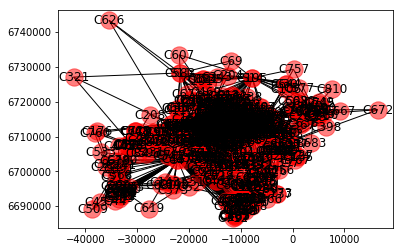

In [26]:
# plot network using matplotlib
fig = plt.figure()
nx.draw_networkx_nodes(G, pos=pos_dict, alpha=0.5)
nx.draw_networkx_labels(G, pos=pos_dict)
nx.draw_networkx_edges(G, pos=pos_dict)
plt.show()

#### Plot the network on map using Bokeh
With bokeh, you are able to drag the map in the default setting and zoom in and out using your trackpad after selecting "Wheel Zoom" in the tool bar. 

All the red dots represent stores, and blue dots represent customers. If you click on any stores, all customers who made purchases in it will be connected. To reset the selection, you can simply click on any space on the map that does not have any dots. To explore the functionalities of the tool bar, place your mouse over the buttons until instructional tags appear.

In [28]:
# setup layout, node sizes and node colors
graph_renderer = from_networkx(G, nx.spring_layout, scale=3, center = (-0.14,51.5))
fixed_layout_provider = StaticLayoutProvider(graph_layout=pos_dict)
graph_renderer.layout_provider = fixed_layout_provider
graph_renderer.node_renderer.data_source.add(size, 'size')
graph_renderer.node_renderer.data_source.add(color, 'color')

# initialize plot
plot = figure(plot_width=800, plot_height=600,
            x_range=(-41000,11000), y_range=(6680000,6750000),
           x_axis_type="mercator", y_axis_type="mercator")
# add map
plot.add_tile(CARTODBPOSITRON_RETINA)

# append network and layout to plot
plot.renderers.append(graph_renderer)
# add interactive functionalities and animations
plot.add_tools(HoverTool(tooltips=None), TapTool(), BoxSelectTool())
graph_renderer.node_renderer.glyph = Circle(size = 'size', fill_color='color')
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color='color')
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])
graph_renderer.edge_renderer.glyph = MultiLine(line_alpha=0, line_width=1)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=1)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=1)
graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()
plot.renderers.append(graph_renderer)
# display plot
output_notebook()
show(plot)

Loading BokehJS ...